# **1<sup>st</sup>: Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

### **Helping Functions**

In [ ]:
# Functions that Takes the excel sheet to make all the columns to be integer numbers only
# ---------------------------------------------------------------------------------------

def round_floats_to_ints(input_dataframe):
    # Round all float columns to integers
    df = input_dataframe.apply(lambda x: x.round() if x.dtype == 'float64' else x)

    return df

In [ ]:
# Function to Find the Empty Cells
# --------------------------------

def find_empty_cells(df):

    # Dictionary to store the indices of empty cells for each column
    empty_cells = {}

    # Iterate through each column in the DataFrame
    for col in df.columns:
        # Find indices of empty cells in the current column
        empty_indices = df[df[col].isna()].index.tolist()
        # Add the empty cell indices to the dictionary
        if len(empty_indices) != 0:
            empty_cells[col] = len(empty_indices)

    return empty_cells

# **2<sup>nd</sup>: Data Importing & Description**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/MohamedMandour10/Datasets/main/cleaned_data.csv')
df.rename(columns={'Pass \nPCP\nPCP + PharmD\nPCP + Consultant\nUrgent PCP': 'target'}, inplace=True)
# df = df.drop('Case NO', axis=1)

In [ ]:
df.head(3)

,Age,Primary Disease,Secondary Diseases,LDL,Number of Meds,Statin Used,Statin Medications,Statin Dose,Current Smoker,Gender,...,Heart Rate,Gold Stage,Gold Group,COPD Pills,Asthma Controlled,Exacerbation Risk,SABA Class,SAMA Class,ICS Dose,target
0,75.00,Hypertension,"Ischemic Stroke, Hyperlipidemia",178.81,1.00,yes,Fluvastatin,41.61,False,male,...,111.00,4,Unknown,yes,poorly controlled,high,yes,no,high Dose,PCP
1,63.00,Hypertension,"Ischemic Stroke, Coronary Artery Disease",115.88,3.00,yes,Fluvastatin,50.22,False,female,...,76.00,1,A,no,well controlled,low,yes,yes,Medium Dose,Urgent PCP
2,49.00,Hypertension,CKD,141.58,3.00,yes,Fluvastatin,71.56,False,male,...,54.00,1,B,no,well controlled,high,no,yes,Medium Dose,Urgent PCP


In [ ]:
df.describe()

,Age,LDL,Number of Meds,Statin Dose,BMI,WC,HDL,Cholesterol,Postprandial,Preprandial,CrCl Test,TSH,Systolic BP,Diastolic BP,Heart Rate
count,903.00,903.00,903.00,437.00,903.00,903.00,903.00,903.00,903.00,903.00,903.00,903.00,903.00,903.00,903.00
mean,62.09,122.22,2.29,34.06,29.48,39.93,59.09,233.28,536.44,254.80,61.29,14.49,154.36,81.94,88.68
std,15.80,43.00,1.74,27.60,6.93,11.48,23.68,91.64,166.14,118.24,34.24,16.89,18.89,19.81,18.99
min,35.00,50.00,0.00,1.00,15.43,20.00,20.00,80.02,113.00,80.00,0.19,0.04,100.00,40.00,30.00
25%,49.00,84.37,1.00,10.42,24.58,30.40,39.00,153.74,419.00,154.00,32.43,5.24,144.00,68.00,74.00
50%,61.00,121.78,2.00,22.90,27.14,39.91,58.00,231.78,546.00,244.00,61.79,10.70,158.00,77.00,88.00
75%,76.00,158.41,3.00,49.83,32.67,49.65,79.00,309.82,678.00,346.00,90.46,16.36,169.00,88.00,104.00
max,90.00,200.00,6.00,89.92,49.76,59.91,100.00,399.84,800.00,500.00,119.95,97.65,180.00,160.00,128.00


# **3<sup>rd</sup>: Data Preprocessing**

### **3.1. Removing Duplicates**

In [ ]:
df = df.drop_duplicates()

### **3.2. Applying Logical Operations on Vitals**

In [ ]:
# Removing Rows with Diastolic More than Systolic
df = df[df['Systolic BP'] >= df['Diastolic BP']]

In [ ]:
# Keep Only Cells that have Systolic is More than Diastolic with Min 20 Points
df = df[df['Systolic BP'] >= df['Diastolic BP'] + 20]

In [ ]:
# Removing Rows with Preprandial More than Postprandial
df = df[df['Postprandial'] >= df['Preprandial']]

In [ ]:
# Keep Only Cells that have Postprandial is More than Preprandial with Min 20 Points
df = df[df['Postprandial'] >= df['Preprandial'] + 20]

### **3.3. Rounding the Dataframe Cells**

In [ ]:
df = round_floats_to_ints(df)

### **3.4. Filling in the Empty Cells**

In [ ]:
empty_cells = find_empty_cells(df)
empty_cells

{'Secondary Diseases': 165,
 'Statin Medications': 466,
 'Statin Dose': 466,
 'ICS Dose': 5,
 'target': 239}

In [ ]:
df.rename(columns={'Statin \nMedications': 'Statin Medications'}, inplace=True)
print(df.columns)

Index(['Age', 'Primary Disease', 'Secondary Diseases', 'LDL', 'Number of Meds',
       'Statin Used', 'Statin Medications', 'Statin Dose', 'Current Smoker',
       'Gender', 'BMI', 'WC', 'HDL', 'Cholesterol', 'Postprandial',
       'Preprandial', 'CrCl Test', 'Insulin\n(Yes / No)', 'TSH', 'Systolic BP',
       'Diastolic BP', 'Heart Rate', 'Gold Stage', 'Gold Group', 'COPD Pills',
       'Asthma Controlled', 'Exacerbation Risk', 'SABA Class', 'SAMA Class',
       'ICS Dose', 'target'],
      dtype='object')


In [ ]:
# Filling in the Statin Medication Column
df['Statin Medications'] = df['Statin Medications'].fillna('No Statin Medication')

# Filling in the Statin Dose Column
df['Statin Dose'] = df['Statin Dose'].fillna(0)

# Filling in the ICS Dose Column
df['ICS Dose'] = df['ICS Dose'].fillna('NO ICS')

# Filling in the ICS Dose Column
df['Secondary Diseases'] = df['Secondary Diseases'].fillna('No Secondary Diseases')

In [ ]:
empty_cells = find_empty_cells(df)
empty_cells

{'target': 239}

# **4<sup>th</sup>: Data Analysis & Visualization**

In [ ]:
# Adding COPD Pills Column & Re-Targeting the COPD Disease Module
# df_cleaned_data = pd.read_excel('cleaned_output_from_pcp.xlsx')
# df_cleaned_data.shape

In [ ]:
df_cleaned_data = df

In [ ]:
df_cleaned_data.head(2)

,Age,Primary Disease,Secondary Diseases,LDL,Number of Meds,Statin Used,Statin Medications,Statin Dose,Current Smoker,Gender,...,Heart Rate,Gold Stage,Gold Group,COPD Pills,Asthma Controlled,Exacerbation Risk,SABA Class,SAMA Class,ICS Dose,target
0,75.00,Hypertension,"Ischemic Stroke, Hyperlipidemia",179.00,1.00,yes,Fluvastatin,42.00,False,male,...,111.00,4,Unknown,yes,poorly controlled,high,yes,no,high Dose,PCP
1,63.00,Hypertension,"Ischemic Stroke, Coronary Artery Disease",116.00,3.00,yes,Fluvastatin,50.00,False,female,...,76.00,1,A,no,well controlled,low,yes,yes,Medium Dose,Urgent PCP


### **4.1. One-Hot-Label Encoding**

In [ ]:
# Split the diseases into a list
df_cleaned_data['Secondary Diseases'] = df_cleaned_data['Secondary Diseases'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the data
one_hot_encoded = mlb.fit_transform(df_cleaned_data['Secondary Diseases'])

# Create a DataFrame with the one-hot encoded data
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_cleaned_data = pd.concat([df_cleaned_data, one_hot_encoded_df], axis=1)

# Drop the original 'Secondary Diseases' column if not needed
df_cleaned_data.drop('Secondary Diseases', axis=1, inplace=True)

In [ ]:
df_cleaned_data.shape

(903, 45)

In [ ]:
df_cleaned_data.head(2)

,Age,Primary Disease,LDL,Number of Meds,Statin Used,Statin Medications,Statin Dose,Current Smoker,Gender,BMI,...,Coronary Artery Disease,Diabetes,Hyperlipidemia,Hypertension,Ischemic Stroke,No Secondary Diseases,Obesity,Obstructive Sleep Apnea,Peripheral Artery Disease,Primary Hypothyroidism
0,75.00,Hypertension,179.00,1.00,yes,Fluvastatin,42.00,False,male,41.00,...,0,0,1,0,1,0,0,0,0,0
1,63.00,Hypertension,116.00,3.00,yes,Fluvastatin,50.00,False,female,26.00,...,1,0,0,0,1,0,0,0,0,0


### **4.2. Numerical Data Visualization**

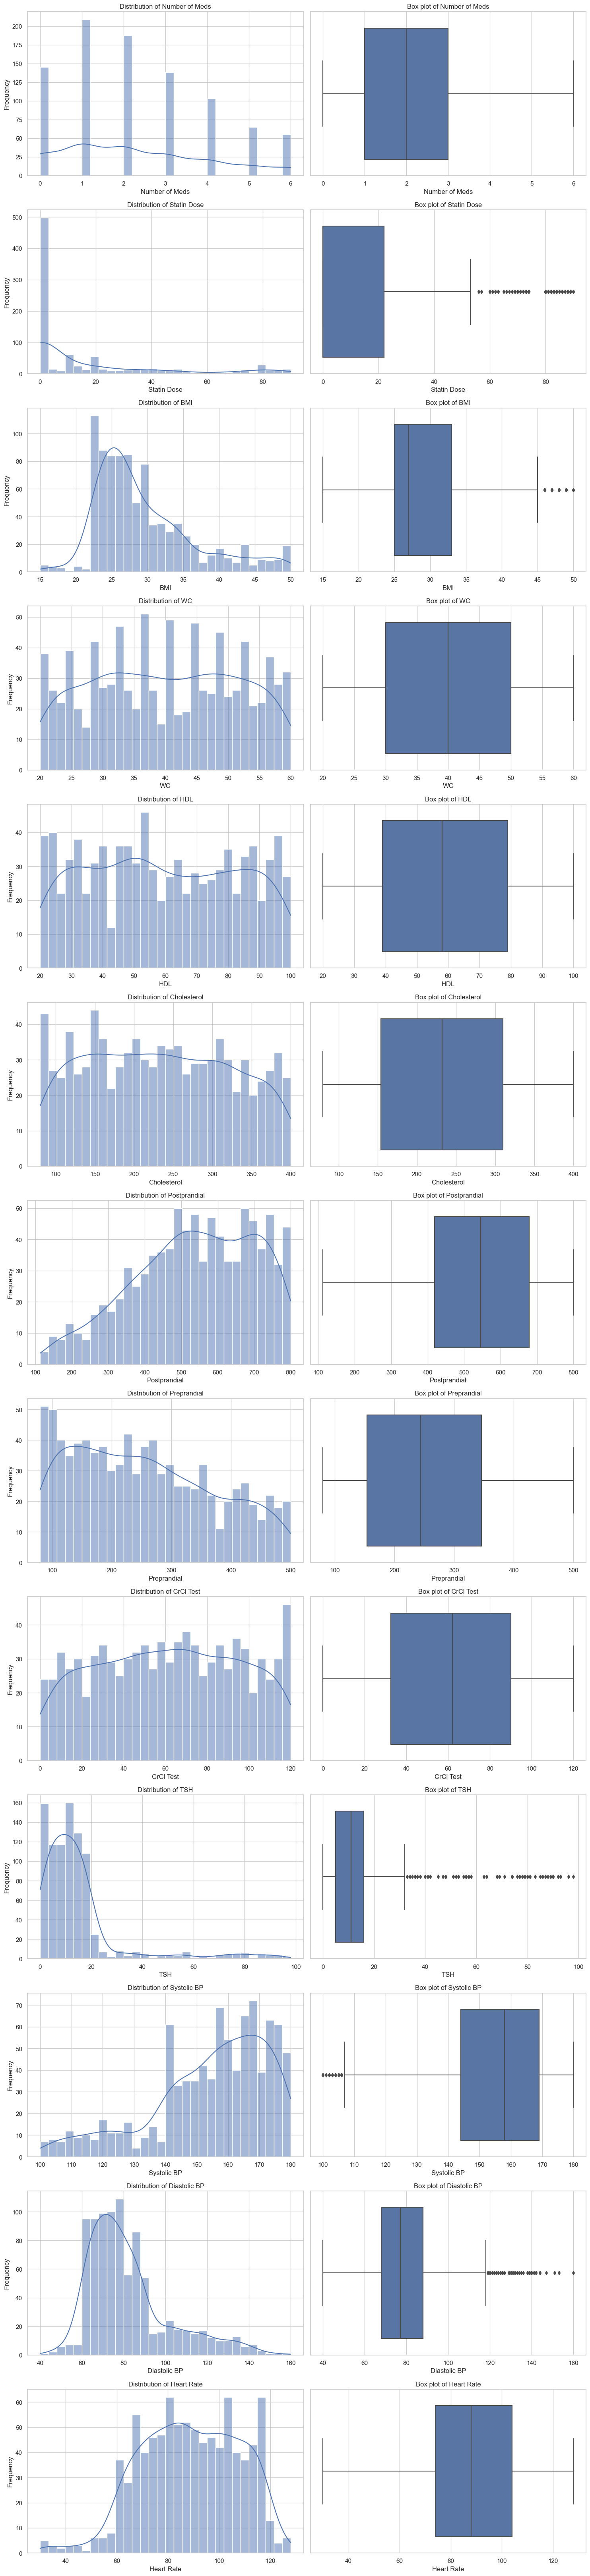

In [ ]:
# Set up the plotting area
sns.set(style="whitegrid")

# Filter numerical columns excluding the first column
num_columns = df_cleaned_data.select_dtypes(include='number').columns[1:15]

# Check if any columns are left to plot
if len(num_columns) < 2:
    print("No numerical columns to plot.")
else:
    # Create a subplot for numerical distributions and box plots
    num_plots = len(num_columns) - 1
    fig, axs = plt.subplots(num_plots, 2, figsize=(15, 5 * num_plots))

    for i, column in enumerate(num_columns[1:]):
        # Distribution plot
        sns.histplot(df_cleaned_data[column], kde=True, bins=30, ax=axs[i, 0])
        axs[i, 0].set_title(f'Distribution of {column}')
        axs[i, 0].set_xlabel(column)
        axs[i, 0].set_ylabel('Frequency')
        # Box plot
        sns.boxplot(x=df_cleaned_data[column], ax=axs[i, 1])
        axs[i, 1].set_title(f'Box plot of {column}')
        axs[i, 1].set_xlabel(column)

    plt.tight_layout()
    plt.show()


### **4.3. Categorical Data Visualization**

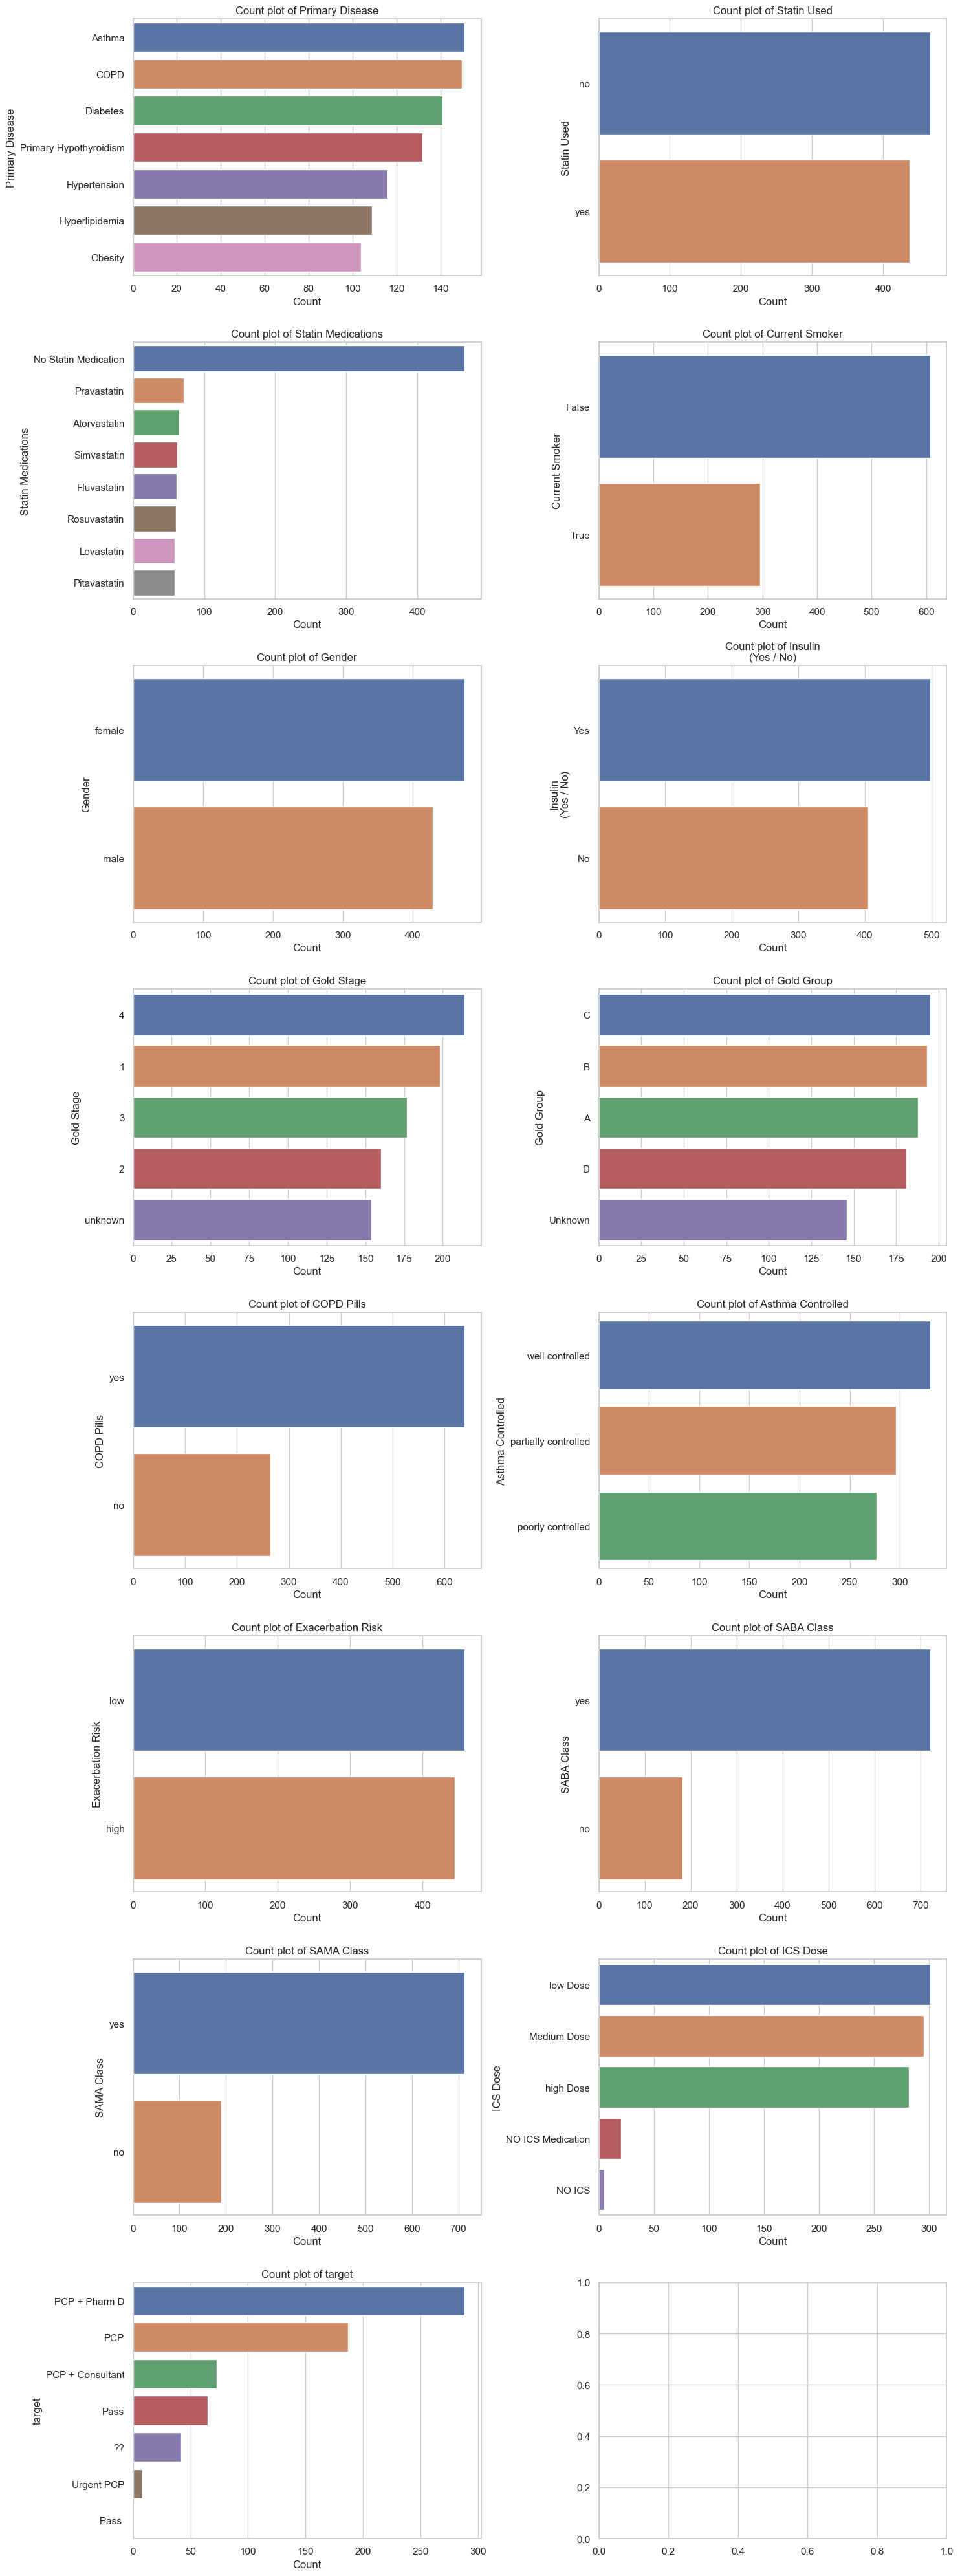

In [ ]:
# Create a subplot for categorical count plots
cat_columns = df_cleaned_data.select_dtypes(include='object').columns
cat_plots = len(cat_columns)
fig, axs = plt.subplots((cat_plots + 1) // 2, 2, figsize=(15, 5 * ((cat_plots + 1) // 2)))


for i, column in enumerate(cat_columns):
    row = i // 2
    col = i % 2
    sns.countplot(y=df_cleaned_data[column], order=df_cleaned_data[column].value_counts().index, ax=axs[row, col])
    axs[row, col].set_title(f'Count plot of {column}')
    axs[row, col].set_xlabel('Count')
    axs[row, col].set_ylabel(column)


plt.tight_layout()
plt.show()

### **4.4. Heatmap**

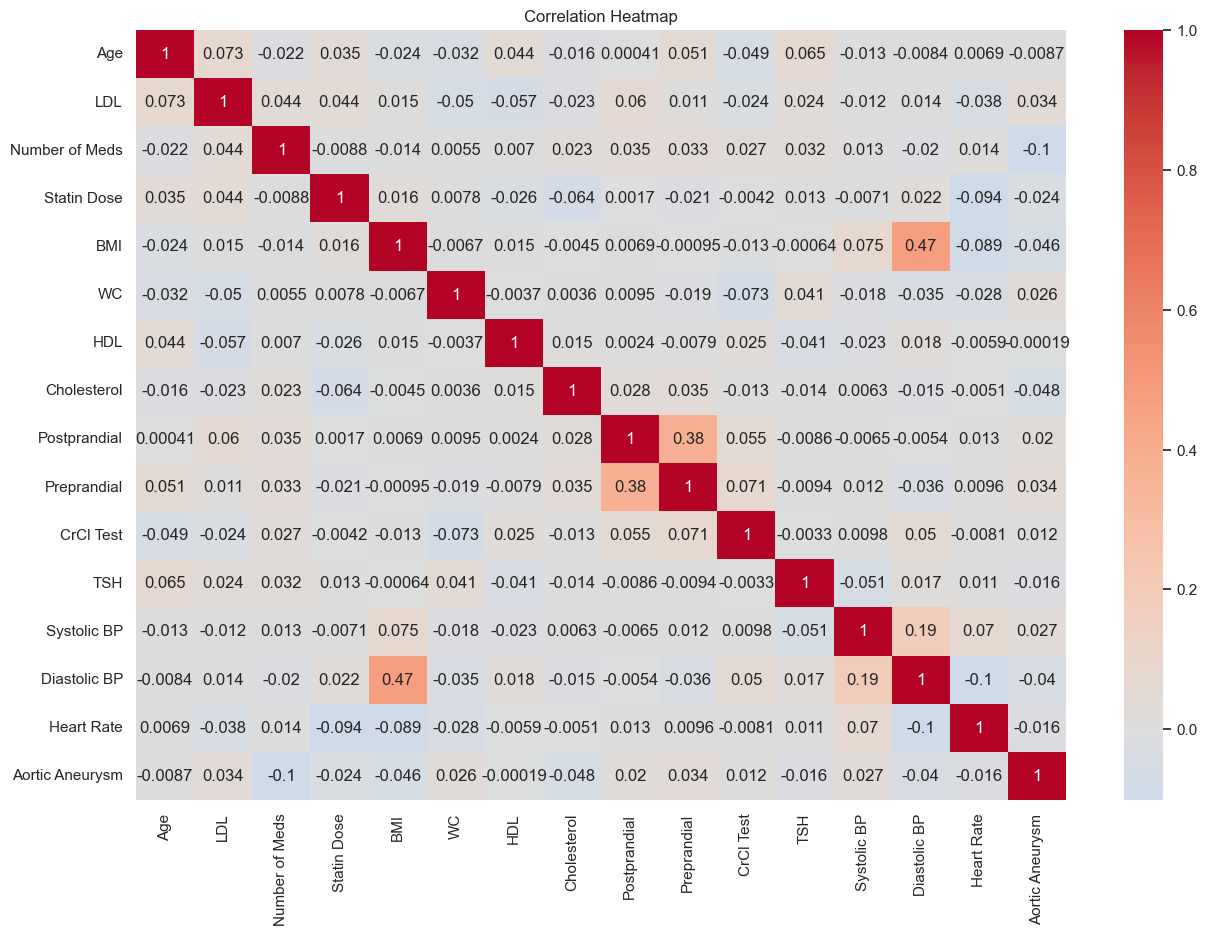

In [ ]:
# Assume df_cleaned_data is your DataFrame
numeric_df = df_cleaned_data.select_dtypes(include='number')

# Exclude columns from index 31 to the end
columns_to_exclude = numeric_df.columns[16:]
filtered_numeric_df = numeric_df.drop(columns=columns_to_exclude)

# Compute the correlation matrix
corr = filtered_numeric_df.corr()

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Feature Selection & Model Building

In [ ]:
print(df_cleaned_data["target"].value_counts())

# Print the number of classes
print("Number of classes:", df_cleaned_data['target'].nunique())

target
PCP + Pharm D       288
PCP                 187
PCP + Consultant     73
Pass                 65
??                   42
Urgent PCP            8
Pass                  1
Name: count, dtype: int64
Number of classes: 7


### Ensuring Consistency in Naming of target's classes

In [ ]:
# Replace "Pass " with "Pass"
df_cleaned_data['target'] = df_cleaned_data['target'].replace('Pass ', 'Pass')

# Replace "??" with "Unknown"
df_cleaned_data['target'] = df_cleaned_data['target'].replace('??', 'Unknown')

df_cleaned_data['target'] = df_cleaned_data['target'].replace('PCP + consultant', 'PCP + Consultant')

df_cleaned_data['target'] = df_cleaned_data['target'].replace('PCP + Pharm D', 'PCP + PharmD')

df_cleaned_data['target'] = df_cleaned_data['target'].replace('PCP ', 'PCP')


In [ ]:
# Drop rows where 'target' is 'Unknown'
df_cleaned_data = df_cleaned_data[df_cleaned_data['target'] != 'Unknown']

In [ ]:
# Check the value counts again
print(df_cleaned_data["target"].value_counts())

# Print the number of classes
print(f"Number of classes: {df_cleaned_data['target'].nunique()}")

target
PCP + PharmD        288
PCP                 187
PCP + Consultant     73
Pass                 66
Urgent PCP            8
Name: count, dtype: int64
Number of classes: 5


In [ ]:
df_cleaned_data

,Age,Primary Disease,LDL,Number of Meds,Statin Used,Statin Medications,Statin Dose,Current Smoker,Gender,BMI,...,Coronary Artery Disease,Diabetes,Hyperlipidemia,Hypertension,Ischemic Stroke,No Secondary Diseases,Obesity,Obstructive Sleep Apnea,Peripheral Artery Disease,Primary Hypothyroidism
0,75.00,Hypertension,179.00,1.00,yes,Fluvastatin,42.00,False,male,41.00,...,0,0,1,0,1,0,0,0,0,0
1,63.00,Hypertension,116.00,3.00,yes,Fluvastatin,50.00,False,female,26.00,...,1,0,0,0,1,0,0,0,0,0
2,49.00,Hypertension,142.00,3.00,yes,Fluvastatin,72.00,False,male,34.00,...,0,0,0,0,0,0,0,0,0,0
3,77.00,Hypertension,74.00,3.00,no,No Statin Medication,0.00,True,female,33.00,...,0,0,0,0,0,0,0,0,0,0
4,42.00,Hypertension,151.00,4.00,yes,Atorvastatin,45.00,False,male,37.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,39.00,Primary Hypothyroidism,69.00,0.00,yes,Atorvastatin,13.00,True,male,26.00,...,0,0,0,0,0,0,0,0,0,0
899,56.00,Primary Hypothyroidism,128.00,2.00,no,No Statin Medication,0.00,False,male,26.00,...,0,0,0,0,0,1,0,0,0,0
900,53.00,Primary Hypothyroidism,87.00,0.00,no,No Statin Medication,0.00,False,female,25.00,...,1,1,0,0,0,0,0,1,0,0
901,81.00,Primary Hypothyroidism,104.00,2.00,yes,Pravastatin,33.00,False,male,23.00,...,0,0,0,0,0,0,0,0,0,0


## Experiment I

### Encoding Binary and Categorical features using `get_dummies`

In [ ]:
# Get the list of categorical columns
categorical_cols = df_cleaned_data.drop(columns=['target'], axis=1).select_dtypes(include=['object']).columns

# Convert categorical columns into dummy variables
df_encoded = pd.get_dummies(df_cleaned_data, columns=categorical_cols)

In [ ]:
df_encoded

,Age,LDL,Number of Meds,Statin Dose,BMI,WC,HDL,Cholesterol,Postprandial,Preprandial,...,Exacerbation Risk_low,SABA Class_no,SABA Class_yes,SAMA Class_no,SAMA Class_yes,ICS Dose_Medium Dose,ICS Dose_NO ICS,ICS Dose_NO ICS Medication,ICS Dose_high Dose,ICS Dose_low Dose
0,75.00,179.00,1.00,42.00,41.00,38.00,53.00,213.00,619.00,347.00,...,False,False,True,True,False,False,False,False,True,False
1,63.00,116.00,3.00,50.00,26.00,23.00,42.00,93.00,416.00,293.00,...,True,False,True,False,True,True,False,False,False,False
2,49.00,142.00,3.00,72.00,34.00,40.00,48.00,119.00,735.00,210.00,...,False,True,False,False,True,True,False,False,False,False
3,77.00,74.00,3.00,0.00,33.00,21.00,45.00,145.00,792.00,424.00,...,False,True,False,False,True,False,False,False,False,True
4,42.00,151.00,4.00,45.00,37.00,23.00,45.00,209.00,506.00,109.00,...,False,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,39.00,69.00,0.00,13.00,26.00,36.00,43.00,155.00,400.00,365.00,...,False,True,False,False,True,True,False,False,False,False
899,56.00,128.00,2.00,0.00,26.00,40.00,65.00,135.00,733.00,442.00,...,True,False,True,False,True,True,False,False,False,False
900,53.00,87.00,0.00,0.00,25.00,28.00,71.00,178.00,143.00,119.00,...,True,False,True,True,False,False,False,False,True,False
901,81.00,104.00,2.00,33.00,23.00,54.00,83.00,183.00,484.00,81.00,...,False,False,True,False,True,False,False,False,True,False


## Data splitting

In [ ]:
# Splitting data into features (X) and target (y)
X = df_encoded.drop(columns=['target'], axis=1)
y = df_encoded['target']

# Perform train-test split with 90% training and 10% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
# Apply one-hot encoding to the target variable
encoder = OneHotEncoder(sparse_output=False)  # the output will be a dense array

# Fit and transform the training target data
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Transform the test target data
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Displaying the results
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train_encoded:", y_train.shape)
print("y_test_encoded:", y_test.shape)

X_train: (688, 79)
X_test: (173, 79)
y_train_encoded: (688,)
y_test_encoded: (173,)


### Base Line Model

In [ ]:
# Create a baseline dummy classifier
dummy_mst_freg = DummyClassifier(strategy="most_frequent")
dummy_stratified = DummyClassifier(strategy="stratified")

# Train the baseline model
dummy_mst_freg.fit(X_train, y_train)
dummy_stratified.fit(X_train, y_train)

# Make predictions
mst_freg_pred = dummy_mst_freg.predict(X_test)
stratified_pred = dummy_stratified.predict(X_test)

# Calculate accuracy
mst_freg_accuracy = accuracy_score(y_test, mst_freg_pred)
model_stratified_accuracy = accuracy_score(y_test, stratified_pred)

print("Baseline Model Using Most Frequent Strategy Accuracy:", mst_freg_accuracy)
print("Baseline Model Using stratified Strategy Accuracy:", model_stratified_accuracy)

Baseline Model Using Most Frequent Strategy Accuracy: 0.37572254335260113
Baseline Model Using stratified Strategy Accuracy: 0.27167630057803466


### XGBoost Classifier

In [ ]:
# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softmax', num_class=len(le.classes_))

# Set up the evaluation data
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model
xgb_clf.fit(X_train, y_train, eval_metric=["mlogloss"], eval_set=eval_set, verbose=False)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Compute the confusion matrix
xg_cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8497109826589595
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.75        35
           1       0.80      0.80      0.80        10
           2       0.81      0.89      0.85        65
           3       1.00      0.33      0.50         9
           4       0.00      0.00      0.00         1
           5       0.95      1.00      0.97        53

    accuracy                           0.85       173
   macro avg       0.72      0.62      0.64       173
weighted avg       0.85      0.85      0.84       173



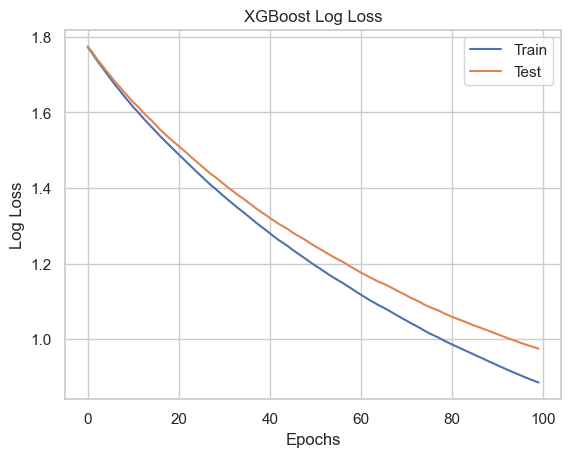

In [ ]:
# Plot the training and test log loss over epochs
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot training and validation log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

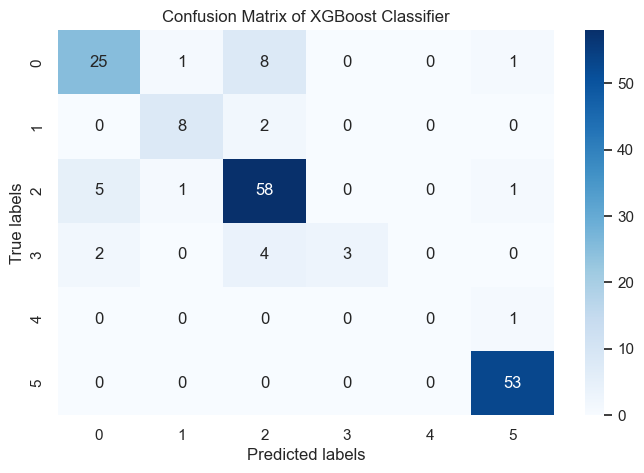

In [ ]:
def plot_cm(cm, title= "Confusion Matrix"):
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, cmap='Blues')

    # Add labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

plot_cm(xg_cm, "Confusion Matrix of XGBoost Classifier")

### Decision Tree Classifier

In [ ]:
# Define Decision Tree classifier
dt = DecisionTreeClassifier()

# Define parameter grid for grid search
param_grid_dt = {
    'max_depth': [3, 4, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_dt.fit(X_train, y_train)
dt_cm = confusion_matrix(y_test, grid_search_dt.predict(X_test))

# Print best parameters and classification report
print("Decision Tree - Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree - Classification Report:")
print(classification_report(y_test, grid_search_dt.predict(X_test)))


Decision Tree - Best Parameters: {'max_depth': 10, 'min_samples_split': 2}
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        35
           1       0.75      0.90      0.82        10
           2       0.97      0.91      0.94        65
           3       0.60      0.67      0.63         9
           4       0.50      1.00      0.67         1
           5       0.98      0.98      0.98        53

    accuracy                           0.90       173
   macro avg       0.77      0.88      0.81       173
weighted avg       0.91      0.90      0.90       173



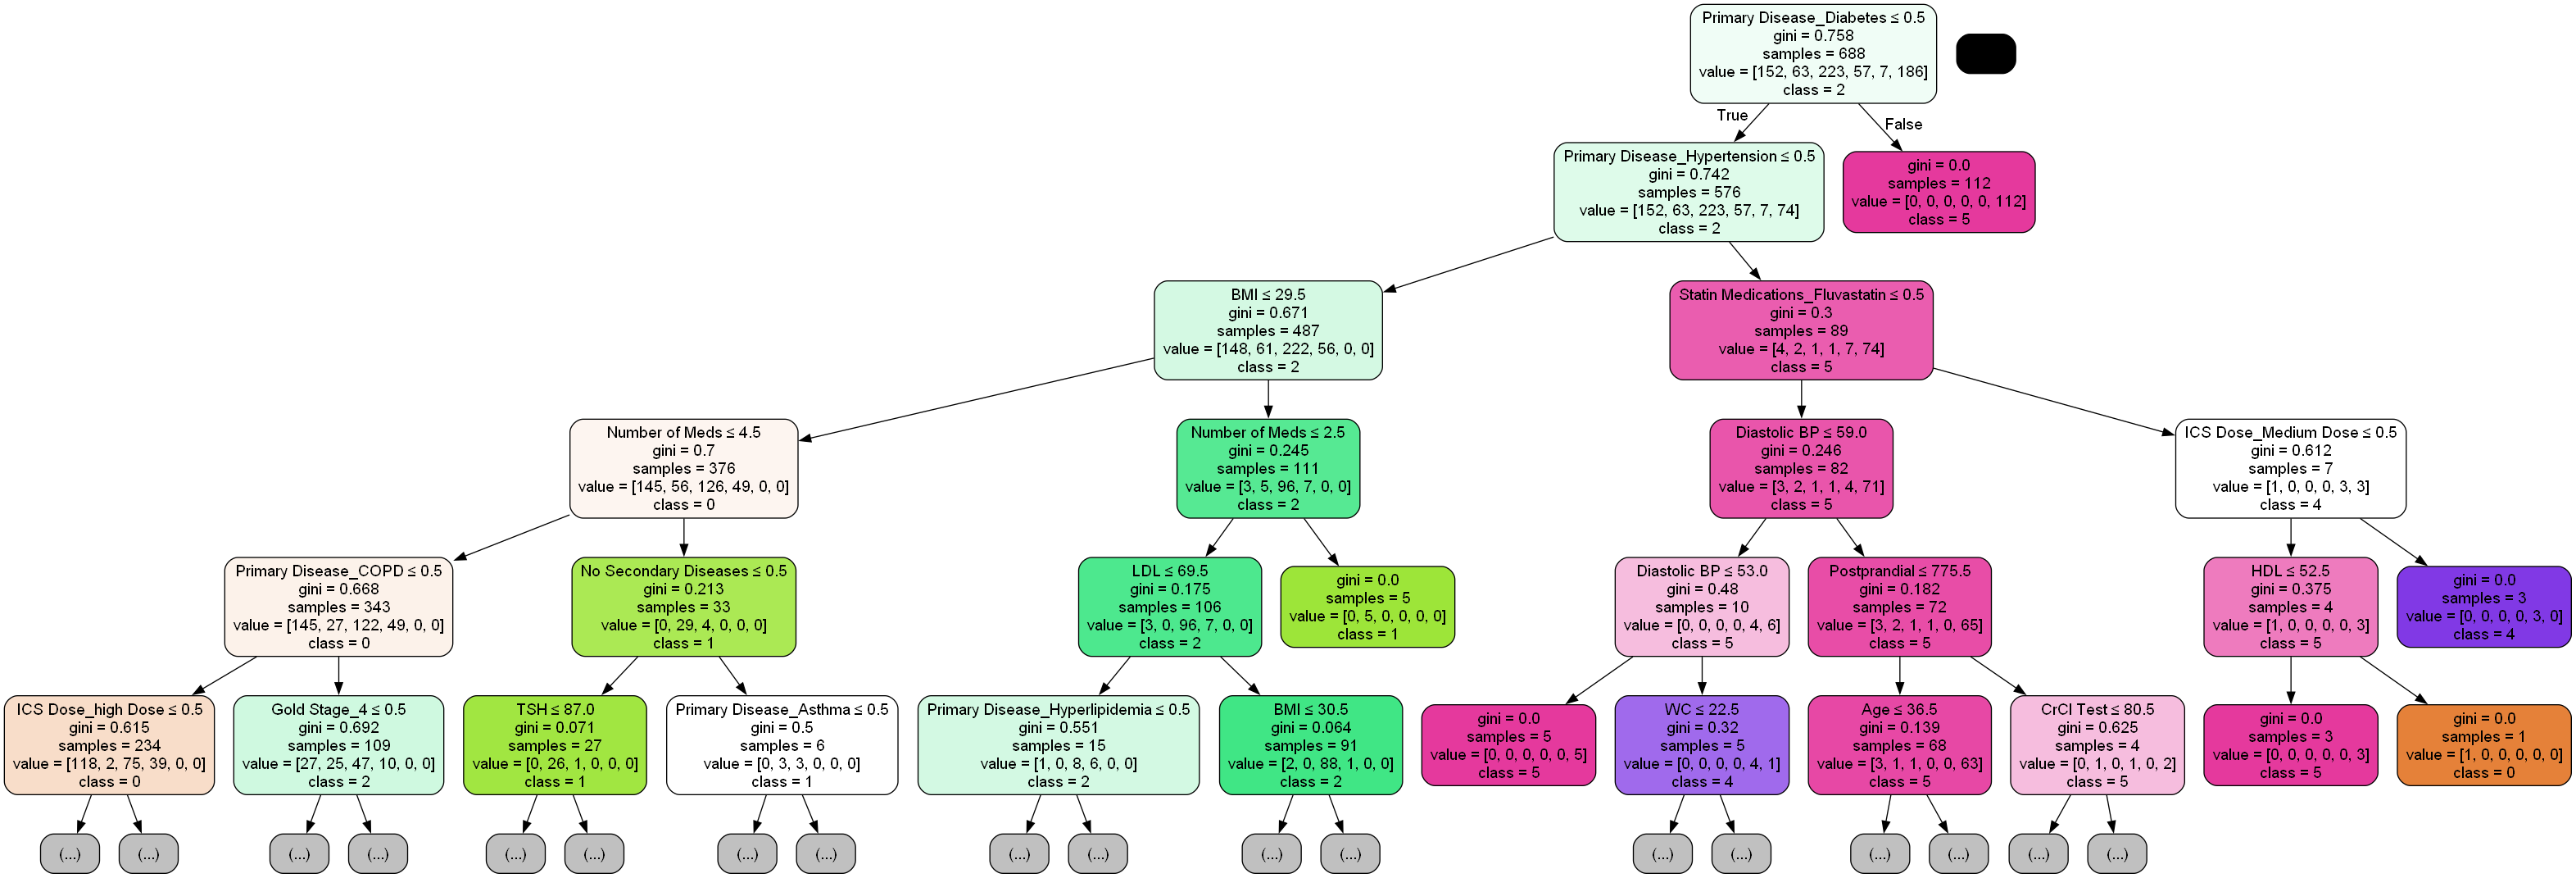

In [ ]:
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

# Get the best decision tree model
best_dt = grid_search_dt.best_estimator_

# Export the decision tree to DOT format
dot_data = export_graphviz(
    best_dt,
    out_file=None,
    feature_names=X_train.columns,
    class_names=np.unique(y_train).astype(str),
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=5  # Limit the depth of the tree
)

# Create a graph from the DOT data
graph = pydotplus.graph_from_dot_data(dot_data)

# Create a PNG image
png_image = graph.create_png()

# Display the tree
Image(png_image)


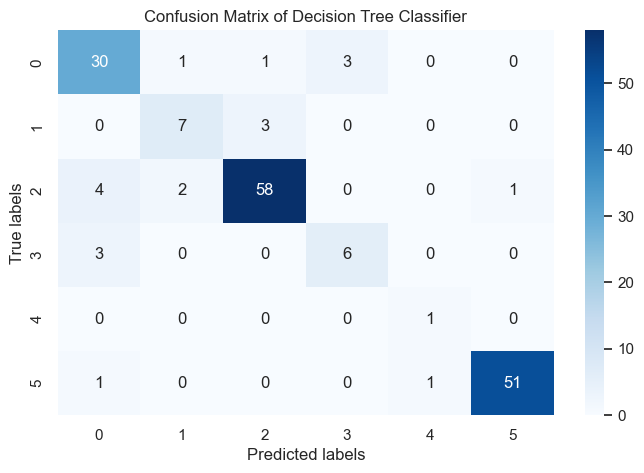

In [ ]:
plot_cm(dt_cm, "Confusion Matrix of Decision Tree Classifier")

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
y_score = best_dt.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

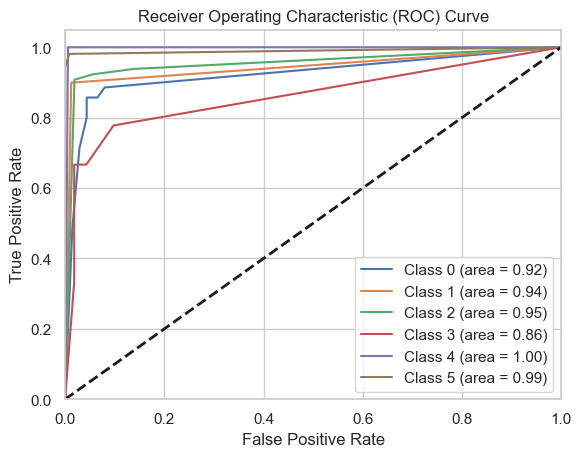

In [ ]:
# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

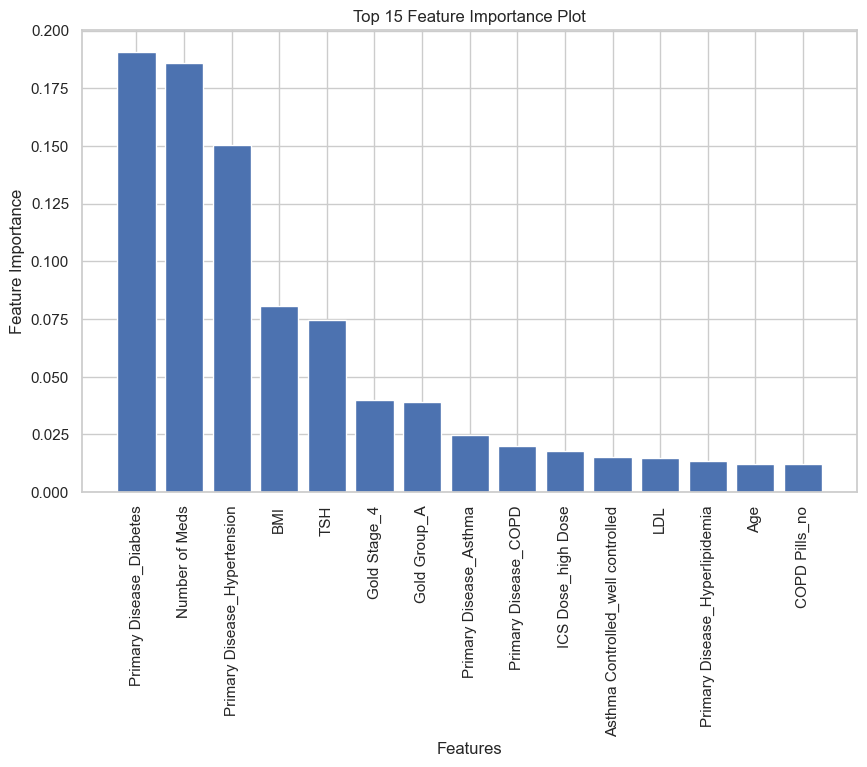

In [ ]:
# Get feature importances
importances = best_dt.feature_importances_
features = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select top 15 features
top_n = 15
sorted_features = [features[i] for i in indices[:top_n]]
sorted_importances = importances[indices][:top_n]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), sorted_importances)
plt.xticks(range(top_n), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Top 15 Feature Importance Plot')
plt.show()

### Random Forest Classifier

In [ ]:
# Define Random Forest classifier
rf = RandomForestClassifier()

# Define parameter grid for grid search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_rf.fit(X_train, y_train_encoded)


# Print best parameters and classification report
print("Random Forest - Best Parameters:", grid_search_rf.best_params_)
print("Random Forest - Classification Report:")
print(classification_report(y_test_encoded, grid_search_rf.predict(X_test)))


Random Forest - Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.40      0.55        35
           1       1.00      0.20      0.33        10
           2       0.93      0.42      0.57        65
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         1
           5       0.95      1.00      0.97        53

   micro avg       0.93      0.55      0.70       173
   macro avg       0.63      0.34      0.40       173
weighted avg       0.87      0.55      0.64       173
 samples avg       0.55      0.55      0.55       173



## Experiment II

### Encoding data with different Approch

In [ ]:
df_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 861 entries, 0 to 902
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        861 non-null    float64
 1   Primary Disease            861 non-null    object 
 2   LDL                        861 non-null    float64
 3   Number of Meds             861 non-null    float64
 4   Statin Used                861 non-null    object 
 5   Statin Medications         861 non-null    object 
 6   Statin Dose                861 non-null    float64
 7   Current Smoker             861 non-null    object 
 8   Gender                     861 non-null    object 
 9   BMI                        861 non-null    float64
 10  WC                         861 non-null    float64
 11  HDL                        861 non-null    float64
 12  Cholesterol                861 non-null    float64
 13  Postprandial               861 non-null    float64
 14 

In [ ]:
df_cleaned_data.columns

Index(['Age', 'Primary Disease', 'LDL', 'Number of Meds', 'Statin Used',
       'Statin Medications', 'Statin Dose', 'Current Smoker', 'Gender', 'BMI',
       'WC', 'HDL', 'Cholesterol', 'Postprandial', 'Preprandial', 'CrCl Test',
       'Insulin\n(Yes / No)', 'TSH', 'Systolic BP', 'Diastolic BP',
       'Heart Rate', 'Gold Stage', 'Gold Group', 'COPD Pills',
       'Asthma Controlled', 'Exacerbation Risk', 'SABA Class', 'SAMA Class',
       'ICS Dose', 'target', 'Aortic Aneurysm', 'Asthma', 'CKD', 'COPD',
       'Carotid Artery Disease', 'Coronary Artery Disease', 'Diabetes',
       'Hyperlipidemia', 'Hypertension', 'Ischemic Stroke',
       'No Secondary Diseases', 'Obesity', 'Obstructive Sleep Apnea',
       'Peripheral Artery Disease', 'Primary Hypothyroidism'],
      dtype='object')

In [ ]:
# Define the column mapping
column_mapping = {
    'Statin Used': {"yes": 1, "no": 0},
    'Current Smoker': {True: 1, False: 0},
    'Gender': {"female": 1, "male": 0},
    'Insulin\n(Yes / No)': {"Yes": 1, "No": 0},
    'SABA Class': {"yes": 1, "no": 0},
    'SAMA Class': {"yes": 1, "no": 0},
    'Exacerbation Risk': {"high": 1, "low": 0},
    'COPD Pills': {"yes": 1, "no": 0},
    'Asthma Controlled': {"well controlled": 1, "poorly controlled": 0, "partially controlled": 2},
    'ICS Dose': {"high Dose": 1, "low Dose": 0, "Medium Dose": 2}
}

In [ ]:
def map_categorical_columns(df, column_mapping):
    """
    Maps values in specified categorical columns of a DataFrame according to the provided mapping.

    Parameters:
    df (pd.DataFrame): The DataFrame containing categorical columns to map.
    column_mapping (dict): Dictionary specifying the mapping for each column.

    Returns:
    pd.DataFrame: The DataFrame with mapped categorical columns.
    """
    df_mapped = df.copy()
    for column, mapping in column_mapping.items():
        df_mapped[column] = df_mapped[column].map(mapping)
    return df_mapped

def encode_dataframe(df, column_mapping):
    """
    Encodes a DataFrame by:
    - Mapping binary categorical features to 0s and 1s.
    - Using pd.get_dummies for other categorical features.

    Parameters:
    df (pd.DataFrame): The DataFrame to encode.
    column_mapping (dict): Dictionary specifying the mapping for each categorical column.

    Returns:
    pd.DataFrame: The encoded DataFrame.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_encoded = df.copy()

    # Apply the function to map categorical columns
    df_mapped = map_categorical_columns(df_encoded, column_mapping)

    # Identify non-binary categorical features (excluding the binary ones)
    non_binary_features = [col for col in df_mapped.columns if df_mapped[col].dtype == 'object' and df_mapped[col].nunique() > 2 and col not in ['Asthma Controlled']]

    # Apply pd.get_dummies to non-binary categorical features
    if non_binary_features:
        df_mapped = pd.get_dummies(df_mapped, columns=non_binary_features)

    return df_mapped


# Assuming df_cleaned_data is your DataFrame
df_encoded_data = encode_dataframe(df_cleaned_data.drop(columns=['target', "Statin Medications", "Gold Stage", "Gold Group"], axis=1),column_mapping )
df_encoded_data["target"] = df_cleaned_data["target"]
df_encoded_data


,Age,LDL,Number of Meds,Statin Used,Statin Dose,Current Smoker,Gender,BMI,WC,HDL,...,Peripheral Artery Disease,Primary Hypothyroidism,Primary Disease_Asthma,Primary Disease_COPD,Primary Disease_Diabetes,Primary Disease_Hyperlipidemia,Primary Disease_Hypertension,Primary Disease_Obesity,Primary Disease_Primary Hypothyroidism,target
0,75.00,179.00,1.00,1,42.00,0,0,41.00,38.00,53.00,...,0,0,False,False,False,False,True,False,False,PCP
1,63.00,116.00,3.00,1,50.00,0,1,26.00,23.00,42.00,...,0,0,False,False,False,False,True,False,False,Urgent PCP
2,49.00,142.00,3.00,1,72.00,0,0,34.00,40.00,48.00,...,0,0,False,False,False,False,True,False,False,Urgent PCP
3,77.00,74.00,3.00,0,0.00,1,1,33.00,21.00,45.00,...,0,0,False,False,False,False,True,False,False,Pass
4,42.00,151.00,4.00,1,45.00,0,0,37.00,23.00,45.00,...,0,0,False,False,False,False,True,False,False,Urgent PCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,39.00,69.00,0.00,1,13.00,1,0,26.00,36.00,43.00,...,0,0,False,False,False,False,False,False,True,PCP
899,56.00,128.00,2.00,0,0.00,0,0,26.00,40.00,65.00,...,0,0,False,False,False,False,False,False,True,PCP + PharmD
900,53.00,87.00,0.00,0,0.00,0,1,25.00,28.00,71.00,...,0,0,False,False,False,False,False,False,True,PCP
901,81.00,104.00,2.00,1,33.00,0,0,23.00,54.00,83.00,...,0,0,False,False,False,False,False,False,True,PCP + PharmD


In [ ]:
ProfileReport(df_encoded_data)

In [ ]:
# Splitting data into features (X) and target (y)
X = df_encoded_data.drop(columns=['target'], axis=1)
y = df_encoded_data['target']

# Perform train-test split with 90% training and 10% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
# Calculate the number of NaN values in the feature matrix X
num_nan_values = X_train.isna().sum().sum() + X_test.isna().sum().sum()

print("Number of NaN values in the feature matrix X:", num_nan_values)

Number of NaN values in the feature matrix X: 25


In [ ]:
# Drop rows with NaN values from the feature matrix X_train and y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]

# Drop rows with NaN values from the feature matrix X_test and y_test
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Print the shape of X_train and X_test after dropping NaN values
print("Shape of X_train after dropping NaN values:", X_train.shape)
print("Shape of X_test after dropping NaN values:", X_test.shape)

Shape of X_train after dropping NaN values: (671, 47)
Shape of X_test after dropping NaN values: (165, 47)


In [ ]:
# Apply one-hot encoding to the target variable
encoder = OneHotEncoder(sparse_output=False)  # the output will be a dense array

# Fit and transform the training target data
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Transform the test target data
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Displaying the results
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train_encoded:", y_train.shape)
print("y_test_encoded:", y_test.shape)

X_train: (671, 47)
X_test: (165, 47)
y_train_encoded: (671,)
y_test_encoded: (165,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV

def apply_rfe(X, y, cv=5):
    """
    Applies Recursive Feature Elimination (RFE) to select features.

    Parameters:
    X (pd.DataFrame): The feature matrix.
    y (pd.Series): The target vector.
    cv (int or cross-validation generator): Determines the cross-validation splitting strategy.

    Returns:
    list: List of selected feature names.
    """

    # Initialize RFE with a DecisionTreeClassifier as estimator
    estimator = DecisionTreeClassifier()
    rfe = RFECV(estimator, cv=cv)

    # Fit RFE
    rfe.fit(X, y)

    # Get selected feature names
    selected_features = X.columns[rfe.support_].tolist()

    return selected_features

# Example usage:
# Assuming X_train and y_train are your feature matrix and target vector
selected_features = apply_rfe(X_train, y_train_encoded)

print("Selected Features:", selected_features)
print("Number of dropped features:" ,X_train.shape[1] - len(selected_features))



Selected Features: ['Age', 'LDL', 'Number of Meds', 'Statin Used', 'Statin Dose', 'Current Smoker', 'Gender', 'BMI', 'WC', 'HDL', 'Cholesterol', 'Postprandial', 'Preprandial', 'CrCl Test', 'Insulin\n(Yes / No)', 'TSH', 'Systolic BP', 'Diastolic BP', 'Heart Rate', 'COPD Pills', 'Exacerbation Risk', 'ICS Dose', 'Asthma', 'Carotid Artery Disease', 'Diabetes', 'Hyperlipidemia', 'Ischemic Stroke', 'Obesity', 'Obstructive Sleep Apnea', 'Peripheral Artery Disease', 'Primary Hypothyroidism', 'Primary Disease_Asthma', 'Primary Disease_COPD', 'Primary Disease_Diabetes', 'Primary Disease_Hyperlipidemia', 'Primary Disease_Hypertension', 'Primary Disease_Primary Hypothyroidism']
Number of dropped features: 10


In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define XGBoost classifier
xgb = XGBClassifier()

# Define parameter grid for grid search
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Grid search with cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_xgb.fit(X_train_scaled, y_train_encoded)

# Print best parameters and classification report
print("XGBoost - Best Parameters:", grid_search_xgb.best_params_)
print("XGBoost - Classification Report:")
print(classification_report(y_test_encoded, grid_search_xgb.predict(X_test_scaled)))


XGBoost - Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68        27
           1       0.60      0.60      0.60        10
           2       0.86      0.66      0.75        65
           3       1.00      0.22      0.36         9
           4       0.00      0.00      0.00         1
           5       0.95      1.00      0.97        53

   micro avg       0.86      0.73      0.79       165
   macro avg       0.69      0.52      0.56       165
weighted avg       0.85      0.73      0.77       165
 samples avg       0.72      0.73      0.73       165



In [ ]:
# Define Decision Tree classifier
dt = DecisionTreeClassifier()

# Define parameter grid for grid search
param_grid_dt = {
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_dt.fit(X_train_scaled, y_train_encoded)

# Print best parameters and classification report
print("Decision Tree - Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree - Classification Report:")
print(classification_report(y_test_encoded, grid_search_dt.predict(X_test_scaled)))


Decision Tree - Best Parameters: {'max_depth': None, 'min_samples_split': 2}
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        27
           1       0.46      0.60      0.52        10
           2       0.84      0.83      0.84        65
           3       0.45      0.56      0.50         9
           4       0.00      0.00      0.00         1
           5       0.96      0.96      0.96        53

   micro avg       0.79      0.79      0.79       165
   macro avg       0.56      0.58      0.57       165
weighted avg       0.80      0.79      0.79       165
 samples avg       0.79      0.79      0.79       165



In [ ]:
# Define Random Forest classifier
rf = RandomForestClassifier()

# Define parameter grid for grid search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_rf.fit(X_train_scaled, y_train_encoded)

# Print best parameters and classification report
print("Random Forest - Best Parameters:", grid_search_rf.best_params_)
print("Random Forest - Classification Report:")
print(classification_report(y_test_encoded, grid_search_rf.predict(X_test_scaled)))


Random Forest - Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.30      0.44        27
           1       0.80      0.40      0.53        10
           2       0.97      0.43      0.60        65
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         1
           5       0.95      1.00      0.97        53

   micro avg       0.94      0.56      0.70       165
   macro avg       0.60      0.35      0.42       165
weighted avg       0.88      0.56      0.65       165
 samples avg       0.56      0.56      0.56       165



In [ ]:
from sklearn.multioutput import MultiOutputClassifier

# Create a Voting Classifier combining the best models
best_estimators = [
    ('xgb', grid_search_xgb.best_estimator_),
    ('dt', grid_search_dt.best_estimator_),
    ('rf', grid_search_rf.best_estimator_)
]

voting_classifier = VotingClassifier(estimators=best_estimators)

# Create a MultiOutputClassifier with the Voting Classifier
multi_voting_classifier = MultiOutputClassifier(voting_classifier)

# Fit the MultiOutputClassifier
multi_voting_classifier.fit(X_train_scaled, y_train_encoded)

# Print classification report for MultiOutputClassifier
print("MultiOutput Voting Classifier - Classification Report:")
print(classification_report(y_test_encoded, multi_voting_classifier.predict(X_test_scaled)))



MultiOutput Voting Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.52      0.64        27
           1       0.55      0.60      0.57        10
           2       0.95      0.57      0.71        65
           3       1.00      0.22      0.36         9
           4       0.00      0.00      0.00         1
           5       0.95      1.00      0.97        53

   micro avg       0.90      0.68      0.77       165
   macro avg       0.71      0.48      0.54       165
weighted avg       0.90      0.68      0.75       165
 samples avg       0.68      0.68      0.68       165



In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for XGBoost model
xgb_accuracy = accuracy_score(y_test_encoded, grid_search_xgb.predict(X_test_scaled))
print("XGBoost - Accuracy:", xgb_accuracy)

# Calculate accuracy for Decision Tree model
dt_accuracy = accuracy_score(y_test_encoded, grid_search_dt.predict(X_test_scaled))
print("Decision Tree - Accuracy:", dt_accuracy)

# Calculate accuracy for Random Forest model
rf_accuracy = accuracy_score(y_test_encoded, grid_search_rf.predict(X_test_scaled))
print("Random Forest - Accuracy:", rf_accuracy)

# Calculate accuracy for Voting Classifier model
voting_accuracy = accuracy_score(y_test_encoded, multi_voting_classifier.predict(X_test_scaled))
print("Voting Classifier - Accuracy:", voting_accuracy)


XGBoost - Accuracy: 0.7090909090909091
Decision Tree - Accuracy: 0.7878787878787878
Random Forest - Accuracy: 0.5636363636363636
Voting Classifier - Accuracy: 0.6787878787878788
